**Author:** Prof. AJ Smit

Department of Biodiversity and Conservation Biology

University of the Western Cape

# Topic 8: Principal Component Analysis (PCA)

PCA is one of many ordination techniques. Depening on the application of technical/scientific discipline it is applied in, you might see it mentioned under 'dimensionality reduction' techniques; other times it is named as a form of 'unsupervised learning.' Regardless of what it is called, ordination refers to multivariate techniques that reduces a multivariate (multi-dimensional) dataset in such a way that when it is projected onto a lower dimensional space, typically 2D or 3D space, any intrinsic structure in the data forms visually-discernable patterns (Pielou, 1984). Ordination summarises community data (e.g. samples of species presence-absence or abundance across muliple sites) by producing a low-dimensional ordination space where similar samples (typically species) plot close together, and dissimilar samples far apart. Dimensions of this low dimensional space represent important and interpretable environmental gradients.

In ecology, ordination techniques are used to describe relationships between community structure patterns and underlying environmental gradients. So, we can ask questions such as, "Which environmental variables cause a community to vary across a landscape?" Ordinations allow us to determine the relative importance of different gradients, and graphical presentations of the results can lead to intuitive interpretations of species-environment relationships.

## Set-up the analysis environment

In [23]:
library(tidyverse)
library(vegan)
library(ggcorrplot) # for the correlations
library(ggpubr)

## The Doubs River data

In [5]:
env <- read.csv("/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/Num_Ecol_R_book_ed1/DoubsEnv.csv")
env <- dplyr::select(env, -1)
head(env)

,dfs,alt,slo,flo,pH,har,pho,nit,amm,oxy,bod
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3,934,48.0,0.84,7.9,45,0.01,0.20,0.00,12.2,2.7
2,2.2,932,3.0,1.00,8.0,40,0.02,0.20,0.10,10.3,1.9
3,10.2,914,3.7,1.80,8.3,52,0.05,0.22,0.05,10.5,3.5
4,18.5,854,3.2,2.53,8.0,72,0.10,0.21,0.00,11.0,1.3
5,21.5,849,2.3,2.64,8.1,84,0.38,0.52,0.20,8.0,6.2
6,32.4,846,3.2,2.86,7.9,60,0.20,0.15,0.00,10.2,5.3


## First do a correlation

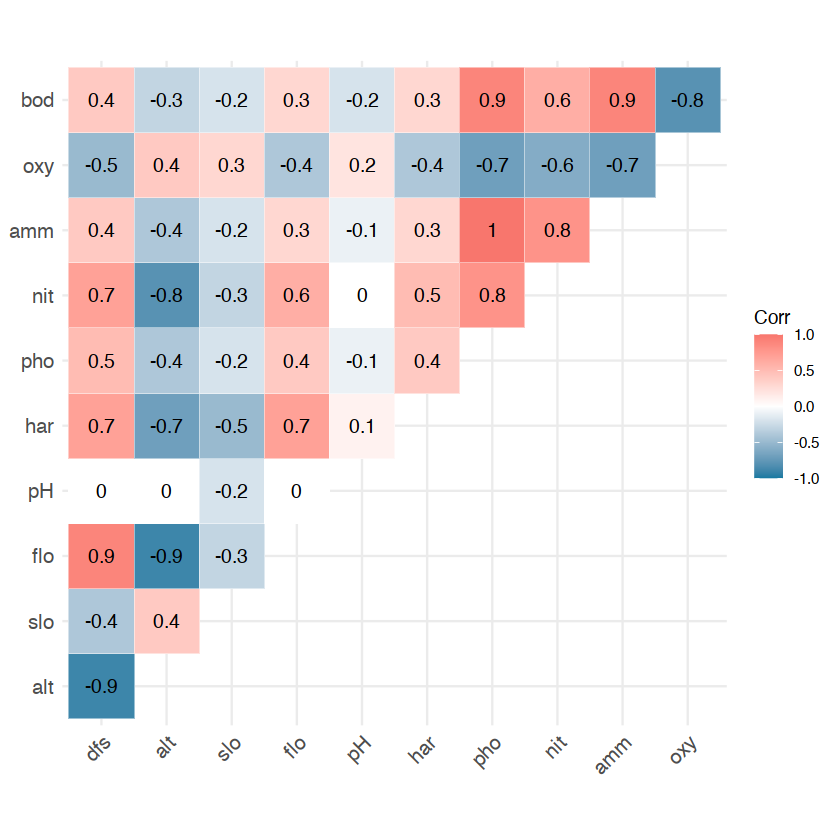

In [6]:
# computing a correalation matrix
corr <- round(cor(env), 1)

# visualization of the correlation matrix
ggcorrplot(corr, type = 'upper', outline.col = "white",
          colors = c("#1679a1", "white", "#f8766d"),
          lab = TRUE)

Some variables are very correlatated, and they might be ommitted from the subsequent analyses. We say that these variables are 'collinear.' Collinear variables cannot be teased apart in terms of finding out which one is most influential in structuring the community. There are more advanced ways to search for collinear variables, and in this way we can systematically exclude them from the PCA. Here we will proceed with all the variables.

## See the spatial context

The patterns in the data and the correlatons between them will make more sense if we can visualise a spatial context. Thankfully spatial data are available:

,X,Y
,<dbl>,<dbl>
1,85.678,20.000
2,84.955,20.100
3,92.301,23.796
4,91.280,26.431
5,92.005,29.163
6,95.954,36.315


Warning message:
“Ignoring unknown parameters: check_overlap”


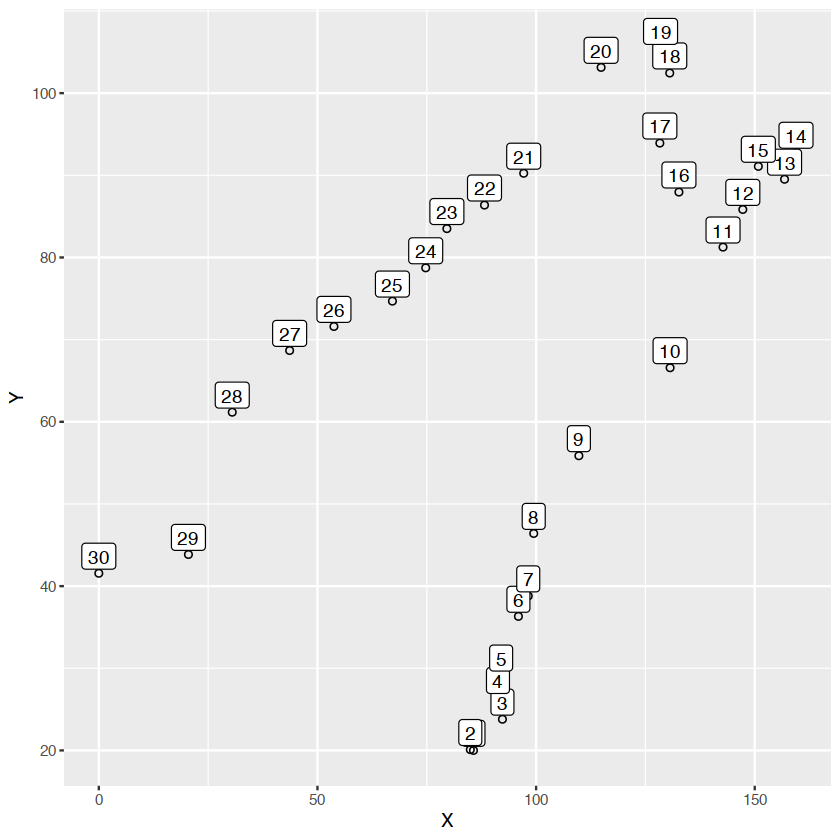

In [39]:
spa <- read.csv("/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/Num_Ecol_R_book_ed1/DoubsSpa.csv")
spa <- dplyr::select(spa, -1)
head(spa)
ggplot(spa, aes(x = X, y = Y, label = rownames(spa))) +
  geom_point(shape = 1) +
  geom_label(vjust = 0, nudge_y = 0.5, check_overlap = TRUE)

We can also scale the symbol size by the magnitude of the environmental variables. Lets look at two pairs of variables that are strongly correlated with one-another:

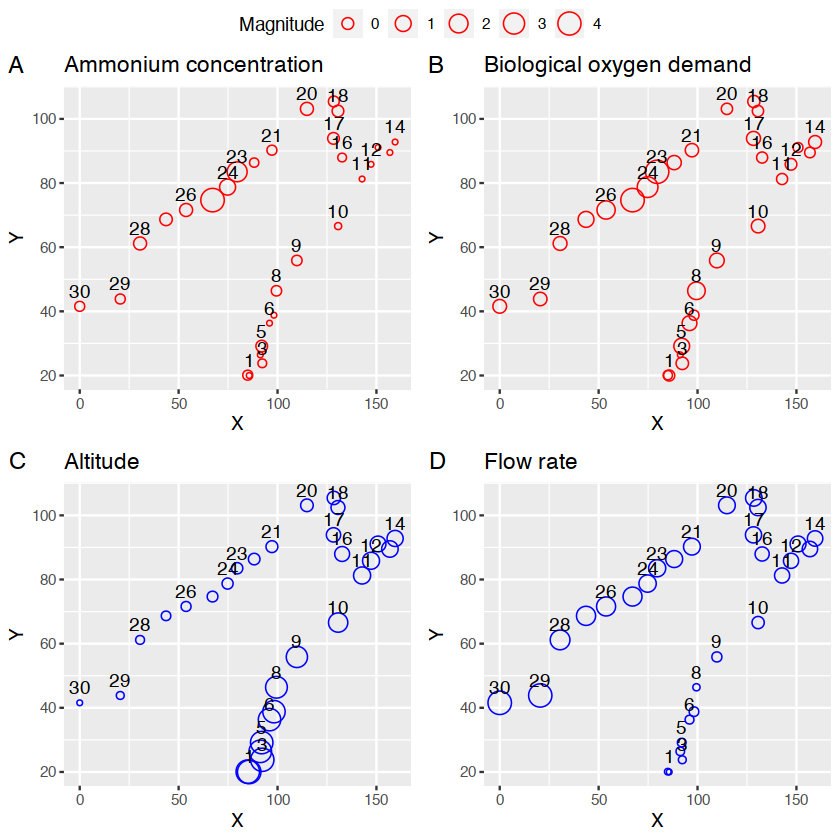

In [46]:
# We scale the data first so as to better represent the full
# magnitude of all variables with a common symbol zise
env_std <- decostand(env, method = "standardize")

# positice correlations
plt1 <- ggplot(spa, aes(x = X, y = Y, label = rownames(spa))) +
  geom_point(shape = 1, col = "red", aes(size = env_std$amm, shape = )) +
  geom_text(vjust = -0.5, nudge_y = 0.5, check_overlap = TRUE) +
  labs(size = "Magnitude", title = "Ammonium concentration")

plt2 <- ggplot(spa, aes(x = X, y = Y, label = rownames(spa))) +
  geom_point(shape = 1, col = "red", aes(size = env_std$bod)) +
  geom_text(vjust = -0.5, nudge_y = 0.5, check_overlap = TRUE) +
  labs(title = "Biological oxygen demand")

# inverse correlations
plt3 <- ggplot(spa, aes(x = X, y = Y, label = rownames(spa))) +
  geom_point(shape = 1, col = "blue", aes(size = env_std$alt)) +
  geom_text(vjust = -0.5, nudge_y = 0.5, check_overlap = TRUE) +
  labs(title = "Altitude")

plt4 <- ggplot(spa, aes(x = X, y = Y, label = rownames(spa))) +
  geom_point(shape = 1, col = "blue", aes(size = env_std$flo)) +
  geom_text(vjust = -0.5, nudge_y = 0.5, check_overlap = TRUE) +
  labs(title = "Flow rate")

ggarrange(plt1, plt2, plt3, plt4, nrow = 2, ncol = 2,
          common.legend = TRUE, labels = "AUTO")

### Questions (A)

* With reference to the sampling design (i.e. position of sample sites along the length of the river), provide mechanistics/ecological reasons for the strongly correlated environmental variables shown above in the pairwise correlation diagram. You might have to create additional spatial maps of scaled variables (as immediately above) to support your answer.

## Do the PCA

We use the function `rda()` to do the PCA. This is the same function that we will use later for a Redundancy Analysis, but when used without specifying constrants (as we do here) it amounts to simply doing a PCA. Typically we standardise environmental data to unit variance, but the PCA accomplishes this step automagically when the argument `scale = TRUE`. PCA can also be applied directly to the raw quantitative data. When applied to environmental data (as we typically do with a PCA) it works with correlations amongst the scaled variables. PCA preserves Euclidean distance and the relationships detected are linear, and for this reason it is not typically applied to species data without suitable transformations. In fact, in this module we will seldom apply a PCA to species data at all. 

In [3]:
env_pca <- rda(env, scale = TRUE)
env_pca

Call: rda(X = env, scale = TRUE)

              Inertia Rank
Total              11     
Unconstrained      11   11
Inertia is correlations 

Eigenvalues for unconstrained axes:
  PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10  PC11 
5.969 2.164 1.065 0.739 0.400 0.336 0.173 0.108 0.024 0.017 0.006 


Ecologists use the term **inertia** as a synonym for 'variation'. In PCA, when we use a correlation matrix (as we do here), the inertia is the sum of the diagonal values of the correlation matrix, which is simply the number of variables (11 in this example). When a PCA uses a covariance matrix the inertia is the sum of the variances of the variables.

You will also see in the output the mention of the term '**unconstrained**'. In a PCA the analysis is always unconstrained (i.e. not influenced by some environmental variables).

The section headed **Eigenvalues for unconstrained axes** shows the relative importance of the resultant reduced axes, and they can be used to determine the proportion of the total inertia (sum of the eigenvalues) captured by any one of the axes. The first eigenvalue (the one associated with PC1) always explains the most variation (the largest fraction), and each subsequent one explains the largest proportion of the *remaining* variance. We say the axes are *orthogonal* and ranked in decreasing order of importance. The sum of all eigenvalue is the total inertia, so collectively they theoretically can explain all of the variation in the dataset (but clearly they *should not* be used to explain *all* the variance). To extract the first eigenvalue we can do:

In [4]:
round(env_pca$CA$eig[1], 3)

PC1 
5.969

The total inertia is:

In [5]:
sum(env_pca$CA$eig)

[1] 11

So the proportion of variation explained by the first PC is:

In [6]:
round(env_pca$CA$eig[1] / sum(env_pca$CA$eig) * 100, 1) # result in %

PC1 
54.3

### Questions (B)

* Why can a PCA, or *any* ordination for that matter, not explain all of the variation in a dataset? In other words, why is it best to only use the first few Principal Components for insight into the drivers of variability? What is 'explained' by the remaining PC axes?

We can show the same information as part of a more verbose summary. Here we see the pre-calculated **Proportion Explained** and **Cumulative Proportion** (it should be obvious what this is). There is also an assortment of other information, viz. **Scaling 2 for species and site scores**, **Species scores**, and **Site scores**. See *Numerical Ecology in R* for their meanings.

In [7]:
summary(env_pca)


Call:
rda(X = env, scale = TRUE) 

Partitioning of correlations:
              Inertia Proportion
Total              11          1
Unconstrained      11          1

Eigenvalues, and their contribution to the correlations 

Importance of components:
                         PC1    PC2     PC3     PC4     PC5     PC6     PC7
Eigenvalue            5.9687 2.1639 1.06517 0.73875 0.40019 0.33563 0.17263
Proportion Explained  0.5426 0.1967 0.09683 0.06716 0.03638 0.03051 0.01569
Cumulative Proportion 0.5426 0.7393 0.83616 0.90332 0.93970 0.97022 0.98591
                           PC8      PC9     PC10     PC11
Eigenvalue            0.108228 0.023701 0.017083 0.005983
Proportion Explained  0.009839 0.002155 0.001553 0.000544
Cumulative Proportion 0.995748 0.997903 0.999456 1.000000

Scaling 2 for species and site scores
* Species are scaled proportional to eigenvalues
* Sites are unscaled: weighted dispersion equal on all dimensions
* General scaling constant of scores:  4.226177 


Species s

**Species scores** are the loadings (a.k.a. rotated and scaled eigenvectors) that indicate the *strength of contribution* of the original environmental variables to the new variables, the Principal Components (PC1, PC2, etc.). Even though we work with environmental data here, these scores are still called species scores by the software---don't let the name confuse you! They indicate how much each of the original environmental variables contribute to PC1, PC2, etc. The larger (more positive) and smaller (more negative) values indicate a greater contribution, albeit in opposite directions. In the example, PC1 is made up of uneven contributions from most of the original variables, with the largest value being nitrate (1.15013) and smallest oxygen (-0.97459). Nitrate and oxygen therefore contribute most towards the differences between sites so that places with more nitrate are also the places with the lowest dissolved oxygen concentration. This makes ecological sense too. pH and slope are the least important variables, i.e. they are least able to explain the differences between sites along PC1. Given the strength of PC1 (it explains 54.3% of the inertia), one might hypothesise that its constituent variables, particularly nitrate and oxygen, influence many aspects of the community. ***The species scores are presented as arrows on the ordination diagrams*** (see below). Longer vectors have a greater influence (are stronger drivers) on environmental (and possibly species) differences between sites, and their direction indicates along which PC axes their influence is greatest.

**Site scores** are the scaled and rotated coordinates of the objects (sites or samples, one for each row of the raw data table). ***They are used to plot the position of the sites in 2D or 3D ordination space***. Sites spread further apart from others in this space differ much in terms of the environmental conditions. How far they spread apart depends on the major environmental gradients indicated by the species scores---i.e. along PC1, sites that are spread far apart in this dimension experience very different concentrations of nitrate and oxygen (see the species scores for the identity of the influential variables).

**Scaling 1** and **Scaling 2**, depending on what was specified in the `rda()` function call, are useful for whether one wants to interpret species (scaling 1) or variables (scaling 2). When calling scaling 1, the distances between points plotted on the ordination diagram will retain their Euclidian distances, which allows for better interpretation of how sites relate to one-another. Calling scaling 2 preserves more accurately the angles between variables with the consequence that in the biplot smaller angles between variable vectors will reflect stronger correlations. More on scaling below.

## Graphical represenations of ordinations

Graphical representations of ordination results are called ordination diagrams. See David Zelený's [exelent writing on the topic](https://www.davidzeleny.net/anadat-r/doku.php/en:ordiagrams).

In a PCA ordination diagram (called a biplot, because it plots two *things*, viz. sites as points and envionmental variables as vectors), following the tradition of scatter diagrams in Cartesian coordinate systems, objects are represented as points and variables are displayed as arrows. We first use the standard **vegan** `biplot()` function:

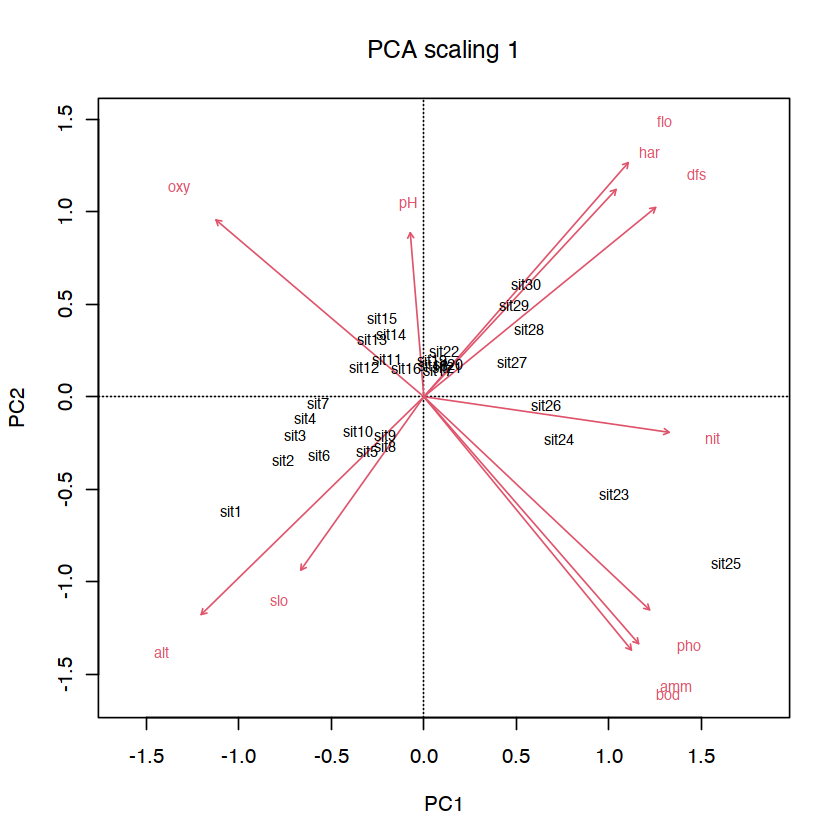

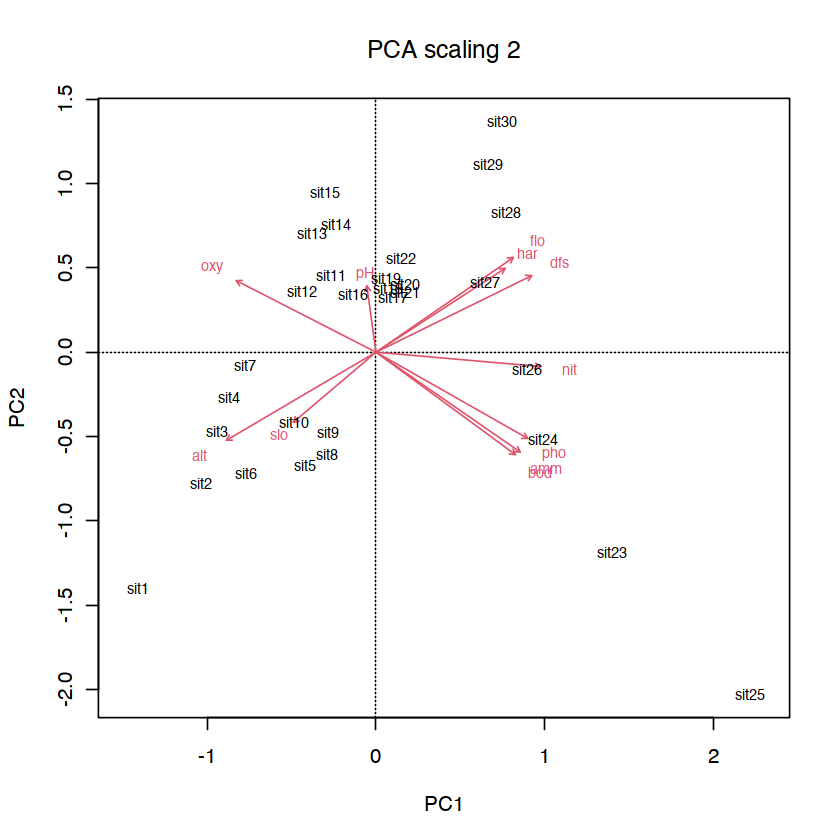

In [8]:
biplot(env_pca, scaling = 1, main = "PCA scaling 1", choices = c(1, 2))
biplot(env_pca, scaling = 2, main = "PCA scaling 2", choices = c(1, 2))

**Scaling 1:** This scaling *emphasises relationships between rows* accurately in low-dimensional ordination space. Distances among objects (samples or sites) in the biplot are approximations of their Euclidian distances in multidimensional space. Objects positioned closer together show a greater degree of environmental dimilarity. The angles among descriptor vectors should not be interpreted as indicating the degree of correlation between the variables.

**Scaling 2:** This scaling *emphasises relationships between columns* accurately in low-dimensional ordination space. Distances among objects (samples or sites) in the biplot are not approximations of their Euclidian distances in multidimensional space. The angles among descriptor vectors can be interpreted as indicating the degree of correlation between the variables.

Now we create biplots using the `cleanplot.pca()` function that comes with *Numerical Ecology in R* book:

circle2 = TRUE 


Warning message in if (class(mat) == "matrix") {:
“the condition has length > 1 and only the first element will be used”


circle2 = TRUE 


Warning message in if (class(mat) == "matrix") {:
“the condition has length > 1 and only the first element will be used”


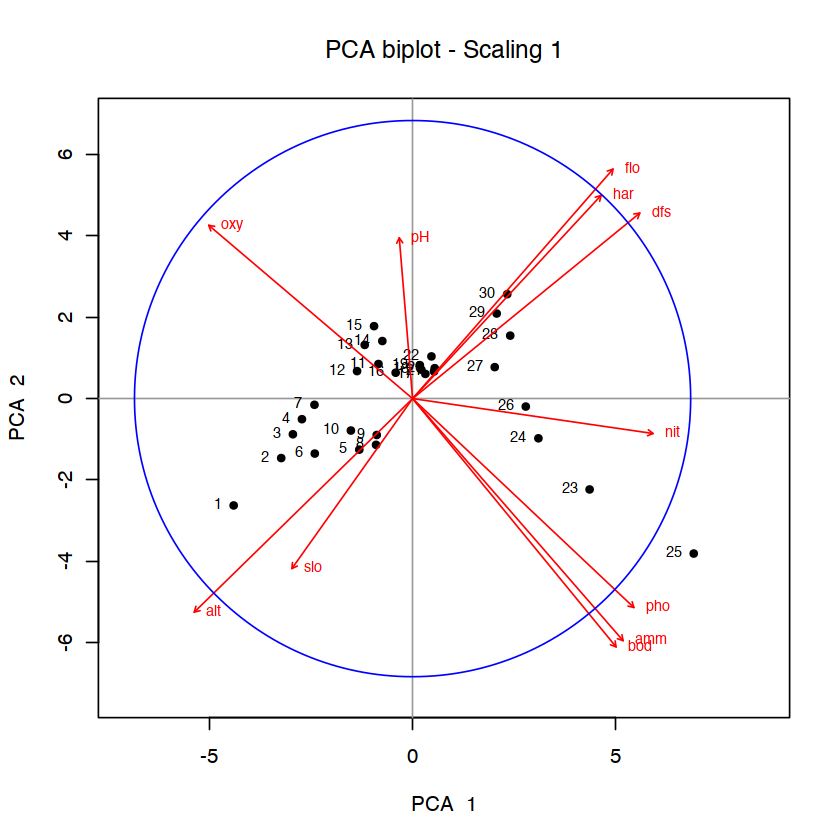

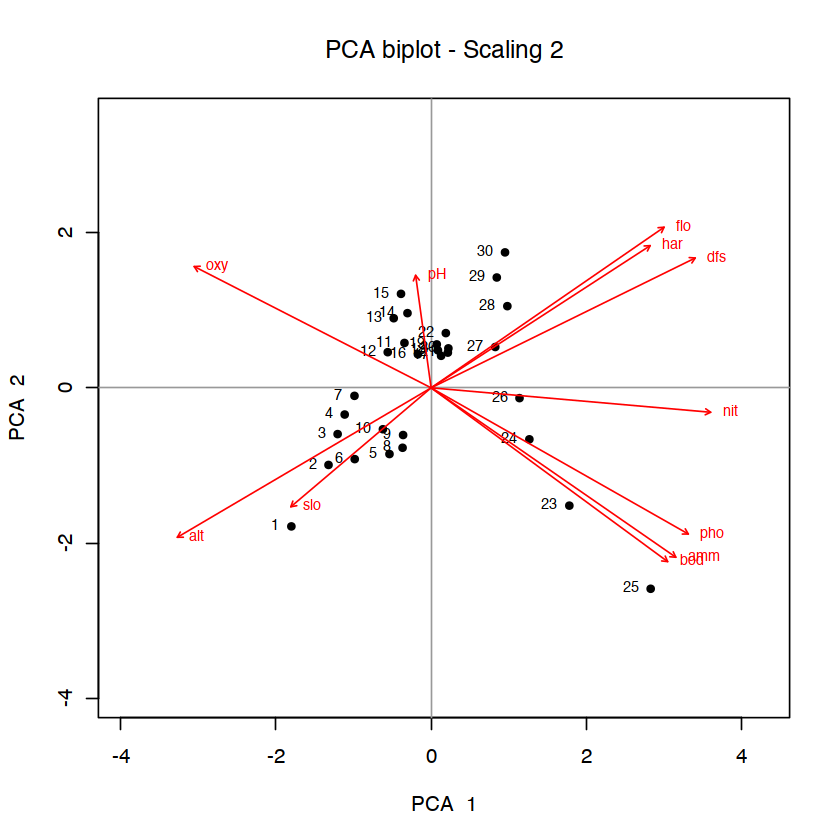

In [11]:
# we need to load the function first from its R file:
source("/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/Num_Ecol_R_book_ed1/cleanplot.pca.R")
cleanplot.pca(env_pca, scaling = 1)
cleanplot.pca(env_pca, scaling = 2)

**At this point it is essential that you refer to *Numerical Ecology in R* (pp. 118 to 126) for help with interpreting the ordination diagrams.**

We can plot the underlying environmental gradients using the `ordisurf()` function in **vegan**. We plot the response surfaces for altitude and biological oxygen demand:


Family: gaussian 
Link function: identity 

Formula:
y ~ poly(x1, 1) + poly(x2, 1)
Total model degrees of freedom 3 

REML score: 46.65864     


Family: gaussian 
Link function: identity 

Formula:
y ~ poly(x1, 1) + poly(x2, 1)
Total model degrees of freedom 3 

REML score: 160.6339     

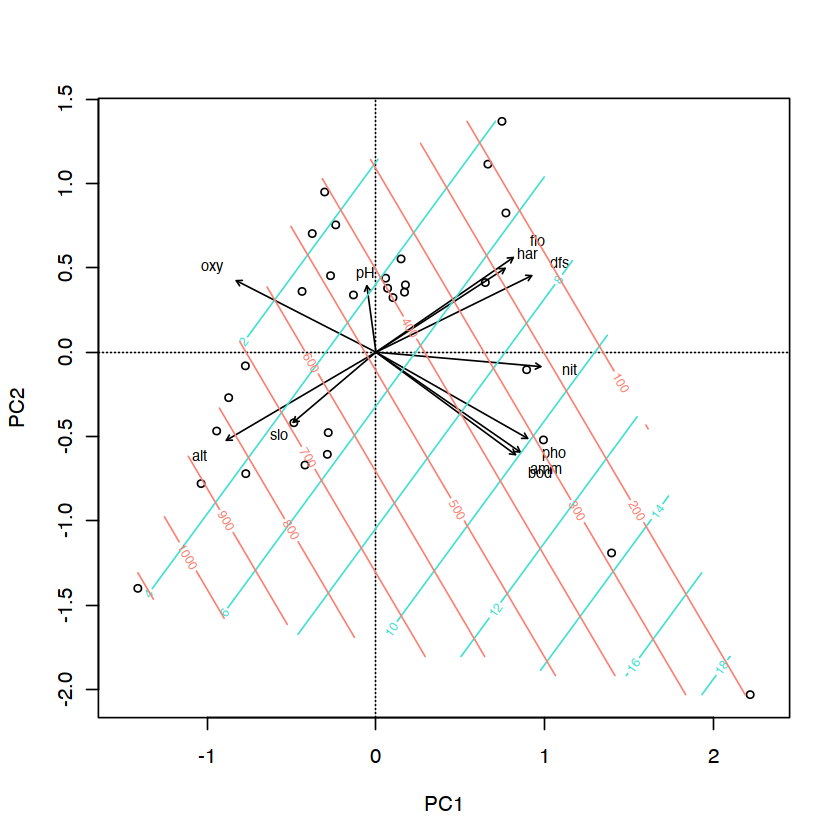

In [12]:
biplot(env_pca, type = c("text", "points"), col = c("black", "black"))
ordisurf(env_pca ~ bod, env, add = TRUE, col = "turquoise", knots = 1)
ordisurf(env_pca ~ alt, env, add = TRUE, col = "salmon", knots = 1)

We see that the contours form a linear trend surface, i.e. they are perpendicular to their vectors. This is the main weakness of PCA, as community data are nonlinear (in fact, environmental gradients are also seldom very linear, but they can be more linear than species data). In general, therefore, PCA should not be used for community data.

### Questions (C)

1. Replicate the analysis shown above on the **environmental data** included with these datasets:
    1. [bird communities along elevation gradient in Yushan Mountain, Taiwan](https://www.davidzeleny.net/anadat-r/doku.php/en:data:ybirds);
    2. [alpine plant communities in Aravo, France](https://www.davidzeleny.net/anadat-r/doku.php/en:data:aravo).
2. Discuss the patterns observed:
    1. explain the ordination diagram with particular reference to the major patterns shown;
    2. provide a mechanistic explanation for the existence of the patterns seen with respect to elevation/altitude; and
    3. if there are significant positive or negative correlations between the environmental variables, provide mechanistic reasons for how they came about.

<span style="color:red">Submit an R script wherein you provide answers to these questions by no later than 17:00 on Tuesday 13 July 2021.</span>